# Fichier de demonstration pour le traitement de données par inférence

## Introduction

L'objectif initial de ce document est de présenter un fichier d'exemples d'application de la librairie IncertitudesMM rédigé dans le cadre pédagogique du BTS Métiers de la Mesure d'une part et la librairie EMCEE permettant un traitement de données par inférence. 

Les fichiers Exemples_IntertitudesMM.py et la librairie IncertitudesMM.py sont disponibles à l'adresse gihub [ici](https://github.com/LegrandR/Python-Incertitudes-BTS-MM) et la librairie EMCEE, à l'adresse [suivante](https://github.com/dfm/emcee)

Ce document propose quelques cas de traitements de données autour d'un modèle linéaire : 
\begin{itemize}
\item cas 1 : incertitude suivant une statistique gaussienne
\item cas 2 : incertitude non gaussienne et non symétrique
\item cas 3 : composition des incertitudes des deux cas précédents
\item cas 4 : modèle linéaire avec valeurs aberrantes
\end{itemize}


Pour chaque cas, une régression linéaire classique et une technique d'inférence seront appliquées et discutées.

Enfin, pour en savoir plus sur les approches récentes d'ajustement d'un modèle à des données, la lecture de [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686) est recommandée.

## Simulation de données expérimentales

### Le problème : Mesure d'une distance par temps de vol

Un émetteur et un capteur sont distant d’une certaine distance. La série de données data  correspond à la distance ($x_i$) et au temps de vol ($y_i$). 

L’objectif est de déterminer un les paramètres a et b d’un modèle affine appliqué à ces données $y = a x + b $

### Génération des données
Pour créer les données expérimentales, nous allons d’abord fixer les paramètres a et b : 
\begin{equation*}
\left\{
    \begin{array}{l}
         a_\text{vrai} = 2 \\
         b_\text{vrai} = 1
    \end{array}
\right.
\end{equation*}


Ce sont les valeurs vrais du modèle au sens métrologique. Valeurs auxquelles nous n’avons pas accès en réalité, mais les données expérimentales seront simulées par tirage aléatoire à partir des valeurs vrai du modèle.

Les valeurs vrais du modèles seront ensuite inférées à partir des données expérimentales générées. Ainsi l’objectif est de montrer la pertinence des outils numériques utilisés pour réaliser ces inférences et comparer les résultats inférés aux valeurs vrais du modèle.


## Incertitudes gausiennes

###  Modules utilisés :



In [1]:
# Module pour le BTS MM
import IncertitudesMM as IMM

#Modules standard
import numpy as np  
import matplotlib.pyplot as plt

# Module fournissant une procédure d'échantillonnage par chaines de Markov
import emcee

   ## Paramètres numériques:

In [2]:
# Permet de varier l'initialisation du générateur pseudo-aléatoire
np.random.seed(120)          

# Paramètre du modèle afine : y = ax + b
a_vrai = 2
b_vrai = 1

# Paramètres des bruits aléatoires
sigma0 = 1

## Génération de données à partir du modèle

Les données générées présentent un bruit gaussien constant sur Y uniquement et de paramètre $\sigma_0$. Il s'agit du cadre d'application stricte de la régression linéaire.

Ce modèle permet de calculer le meilleur estimateur pour les paramètres a et b de la loi, ainsi que l'écart-type pour ces deux paramètres.

Remarque : le modèle de la régression linéaire  est un résultat d'algèbre linéaire et se généralise sans difficulté à n'importe quel polynôme.

In [3]:
N = 20  #Nombre de points
Xdata = np.sort(10 * np.random.rand(N)) # X aléatoires
Yvrai = a_vrai * Xdata + b_vrai         # Données vraies issues du modéle
Ydata = np.random.normal(Yvrai, sigma0) # Bruit gaussien

Tracé de data = {$X_\text{vrai}$, $Y_\text{vrai}$, $\sigma_0$} et la loi vrai

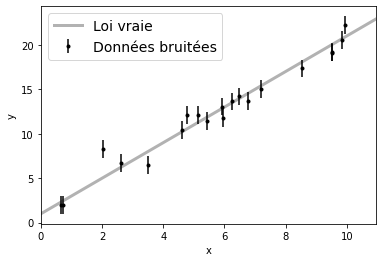

In [4]:
plt.figure(0)
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0, label = "Données bruitées")
x0 = np.linspace(0, max(Xdata)+1, 500)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", alpha=0.3, lw=3, label="Loi vraie")
plt.xlim(0, max(Xdata)+1)
plt.xlabel("x")
plt.ylabel("y");
plt.legend(fontsize=14)

   ## Régression linéaire : RL
   
   Permet de calculer le meilleur estimateur de a et b connaissant un jeu de donnée {Xdata, Ydata}, l'incertitude suivant une statistique gaussienne de paramètre $\sigma_0$

In [5]:
Out = IMM.LinearReg(Xdata,Ydata,sigma0)
a_RL = Out.A                #Estimateur de a_vrai    
b_RL = Out.B                #Estimateur de b_vrai
Sigma_a_RL = Out.SigmaA     #Ecart-type sur a
Sigma_b_RL = Out.SigmaB     #Ecart-type sur b

Tracé de data = {$X_i$, $Y_i$} et de la régression linéaire :

Regression linéaire :
a_RL = 1.914 ± 0.080
b_RL = 1.516 ± 0.512


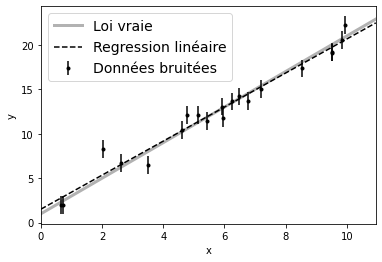

In [6]:
plt.figure(1)
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0, label = "Données bruitées")
x0 = np.linspace(0, max(Xdata)+1, 500)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", alpha=0.3, lw=3, label="Loi vraie")
plt.plot(x0, a_RL * x0 + b_RL, "--k", label="Regression linéaire")
plt.legend(fontsize=14)
plt.xlim(0, max(Xdata)+1)
plt.xlabel("x")
plt.ylabel("y");

print("Regression linéaire :")
print("a_RL = {0:.3f} ± {1:.3f}".format(Out.A,Out.SigmaA))
print("b_RL = {0:.3f} ± {1:.3f}".format(Out.B, Out.SigmaB))

## Méthode de l'estimateur du maximum de vraisemblance (Fisher 1922)

Cette technique consiste à déterminer des paramètres (ici a et b) pour
maximiser une fonction vraisemblance.

### Fonction de vraisemblance du modèle

La fonction de vraisemblance du modèle doit correspondre aux informations connues du modèle et du bruit. 
Le modèle est : 
\begin{equation*}
y_\text{vrai}  = a\cdot x + b
\end{equation*}

Et l'incertitude suit une loi gaussienne, la probabilité d'obtenir une donnée $y_\text{i}$ data est : 
\begin{equation*}
p(y_\text{i}) = \dfrac{1}{\sigma_0\cdot\sqrt{2\pi}}\cdot \exp\left( \dfrac{1}{2}\cdot\left( \dfrac{y_\text{i} - y_\text{vrai}}{\sigma_0}\right)^2\right)
\end{equation*}

La probabilité d'obtenir l'ensemble des données $y_\text{data} = \lbrace y_i\rbrace$ est donc : 
\begin{equation*}
p(y_\text{data}) = \prod_i p(y_\text{i})
\end{equation*}

La fonction de vraisemblance est une fonction de paramètre a et b maximisant cette probabilité $p(y_\text{data})$. Son logarithme est défini par : 
\begin{equation*}
\ln p(y_\text{data} | a,b, \sigma_0) = -\dfrac{1}{2}\sum_i \left[\dfrac{(y_i - a x_i - b)^2}{\sigma_0^2} \right] + \text{constante} 
\end{equation*}

In [8]:
# Module pour le calcul des paramètres maximisant la fonction de vraisemblance
# La fonction vraisemblance précédente est utilisée dans la librairie.

Out = IMM.MaxVraissemblance2parametres(Xdata,Ydata,sigma0)
a_MV = Out.A
b_MV = Out.B


print("Estimation par maximum de vraisemblance :")
print("a = {0:.3f}".format(a_MV))
print("b = {0:.3f}".format(b_MV))



Estimation par maximum de vraisemblance :
a = 1.914
b = 1.516


Sans surprise, cette méthode donne les mêmes résultats que la méthode de régression linéaire : ces deux techniques sont toutes deux issues de méthodes d'évaluation d'estimateur par la méthode des moindres carrés. Dans ce cas précis, elles sont rigoureusement équivalentes.
La régression linéaire à l'avantage de fournir directement une estimation des écarts-types sur les paramètres estimés.

### Maximisation de la fonction vraisemblance par échantillonnage par chaînes de Markov

La démarche est similaire à la méthode précédente : il s'agit de maximiser une fonction vraisemblance identique à la précédente. La différence majeur réside dans la technique utilisée : les paramètres du système (a et b) sont déterminés par une exploration stochastique de l'espace des paramètres (chaînes de Markov). Cette technique permet d'imager la statistique à laquelle répondent les paramètres a et b et donc d'en extraire les quantiles à 16 et 68% correspondant au plus ou moins un écart-type de la loi Normale.

In [9]:
def log_incertitudeNormale(theta, x, y, sigma):
    a, b = theta
    model = a * x + b
    sigma2 = sigma ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Precision = 10

nwalkers = 5*Precision  # number of MCMC walkers
nburn = 500*Precision  # "burn-in" period to let chains stabilize
nsteps = nburn + 2000*Precision  # number of MCMC steps to take

pos = [2,1] + 1e-1 * np.random.randn(nwalkers, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_incertitudeNormale, args=(Xdata, Ydata, sigma0))
sampler.run_mcmc(pos, nsteps, progress=True);
flat_samples = sampler.get_chain(discard=nburn, thin=15, flat=True)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:25<00:00, 974.11it/s]


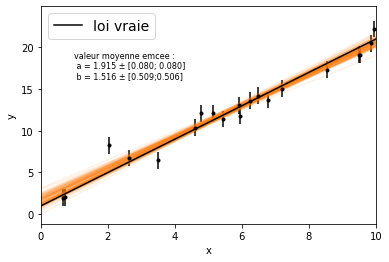

In [10]:
sol=[]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)

    sol.append(mcmc[1])
    sol.append(q[0])
    sol.append(q[1])
    
    inds = np.random.randint(len(flat_samples), size=100)
plt.figure(4)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
    
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", label="loi vraie")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.text(1.0,15, "valeur moyenne emcee :\n a = {0:.3f} ± [{1:.3f}; {2:.3f}]\n b = {3:.3f} ± [{4:.3f};{5:.3f}]\n"\
         .format(sol[0],sol[1],sol[2],sol[3],sol[4],sol[5]),fontsize=8);

Les estimateurs obtenus sont identiques, aux erreurs numériques prés, aux estimateurs calculés avec une méthode de régression linéaire. Les hypothèses de calcules étant les mêmes, les grandeurs calculées sont donc forcément les mêmes.

##  Bruit non gaussien et non symétrique : cas d'un système de mesure avec temps morts.

Mettons nous dans la situation d'un système de mesure présentant des temps mort. Cela signifie qu'un signal arrivant pendant ce temps mort sera détecté avec un délais au maximum égal à la durée de ce temps mort. 
L'incertitude associée sera de la forme : 
\begin{equation*}
p(y_i) = \left\{
    \begin{array}{ll}
        \dfrac{1}{\tau} & \mbox{si } 0 \leq y_i - y_\text{vrai} \leq \tau  \\
        0 & \mbox{sinon.}
    \end{array}
\right.
\end{equation*}

Il s'agit d'une incertitude suivant une [Loi uniforme continue (Wikipedia)](https://fr.wikipedia.org/wiki/Loi_uniforme_continue)

Pour $\tau = 5$, les données générées ont l'allure suivante : 

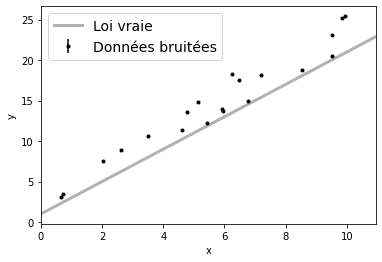

In [11]:
""" Paramètres :"""
# Permet de varier l'initialisation du générateur pseudo-aléatoire
np.random.seed(120)          

# Paramètre du modèle afine : y = ax + b
a_vrai = 2
b_vrai = 1

# Paramètres des bruits aléatoires
sigma0 = 0
tau = 5


""" Génération de données à partir du modèle """
N = 20
Xdata = np.sort(10 * np.random.rand(N))
Yvrai = a_vrai * Xdata + b_vrai
Ydata = Yvrai + np.random.uniform(0,  tau, N)


""" Tracé de data = {Xvrai, Yvrai, sigma0} et la loi vrai """
plt.figure(0)
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0, label = "Données bruitées")
x0 = np.linspace(0, max(Xdata)+1, 500)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", alpha=0.3, lw=3, label="Loi vraie")
plt.xlim(0, max(Xdata)+1)
plt.xlabel("x")
plt.ylabel("y");
plt.legend(fontsize=14)

Sans surprise, les données sont toutes au dessus de la loi vraie.

### Régression linéaire
Appliquons une procédure de régression linéaire avec pour incertitude $\sigma = \frac{\tau}{\sqrt{12}}$ pour coller au mieux aux estimateurs et à la connaissance du modèle.

Regression linéaire :
a_RL = 2.146 ± 0.115
b_RL = 2.386 ± 0.739


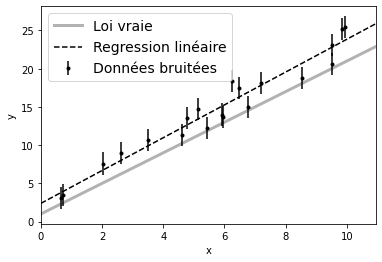

In [12]:
""" Régression linéaire : RL """

""" Permet de calculer le meilleur estimateur de a et b
connaissant un jeu de donnée {Xdata, Ydata}, l'incertitude suivant une 
statistique gausienne de paramètre sigma0 """

sigma0 = tau / np.sqrt(12)

Out = IMM.LinearReg(Xdata,Ydata,sigma0)
a_RL = Out.A                #Estimateur de a_vrai    
b_RL = Out.B                #Estimateur de b_vrai
Sigma_a_RL = Out.SigmaA     #Ecart-type sur a
Sigma_b_RL = Out.SigmaB     #Ecart-type sur b

""" Tracé de data et de la regression linéaire"""
plt.figure(1)
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0, label = "Données bruitées")
x0 = np.linspace(0, max(Xdata)+1, 500)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", alpha=0.3, lw=3, label="Loi vraie")
plt.plot(x0, a_RL * x0 + b_RL, "--k", label="Regression linéaire")
plt.legend(fontsize=14)
plt.xlim(0, max(Xdata)+1)
plt.xlabel("x")
plt.ylabel("y");

print("Regression linéaire :")
print("a_RL = {0:.3f} ± {1:.3f}".format(Out.A,Out.SigmaA))
print("b_RL = {0:.3f} ± {1:.3f}".format(Out.B, Out.SigmaB))


Le calcul d'estimateurs a et b fait exactement ce qu'il est supposé faire : minimiser l’écart quadratique moyen entre le modèle et les données. Ces estimateurs a et b sont les meilleurs uniquement si les hypothèses permettant l'application de cette procédure sont respectées. En particulier, l'application de la régression linéaire nécessite au minimum que la plage d'incertitude soit centrée sur la valeur vraie pour extraire des paramètres non aberrants. Ce n'est plus le cas ici, d'où les paramètres aberrants.



### Maximisation de la fonction vraisemblance

La fonction vraisemblance utilisée est la suivante : 

\begin{equation*}
p(y_\text{data}) = \prod_i p(y_i) 
\end{equation*}
 
 avec

\begin{equation*}
p(y_i) = \left\{
    \begin{array}{ll}
        \dfrac{1}{\tau} & \mbox{si } 0 \leq y_i - y_\text{vrai} \leq \tau  \\
        0 & \mbox{sinon.}
    \end{array}
\right.
\end{equation*}

Pour des questions d'algorithmie, nous allons utiliser le logarithme de la fonction vraisemblance. Le logarithme étant une fonction croissante monotone, maximiser $\log p(y_\text{data})$ permet de répondre au problème.

Cette fonction possède 3 paramètres : a, b et $\tau$.

In [13]:
def log_VraisemblanceUniforme(theta, x, y):
    a, b, tau = theta
    model = a * x + b
    Py = (((y - model) <= tau) * ((y - model) >= 0)) /tau
    if (Py == 0).any() :
        return -np.inf
    else :
        return np.sum(np.log(Py))
   

Precision = 5

nwalkers = 5*Precision  # Paramètre EMCEE : nombre de "marcheurs"
nburn = 2000*Precision  # Paramètre EMCEE : nombre de points avant stabilisation des chaînes
nsteps = nburn + 2000*Precision  # Paramètre EMCEE : nombre de pas

pos = [2,1,5] + 1e-1 * np.random.randn(nwalkers, 3) # Position initiale permettant d'accélérer la convergence
nwalkers, ndim = pos.shape # Paramètre EMCEE

#Algorithme EMCEE
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_VraisemblanceUniforme, args=(Xdata, Ydata))
sampler.run_mcmc(pos, nsteps, progress=True);
flat_samples = sampler.get_chain(discard=nburn, thin=15, flat=True)



  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\Prof\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1385.00it/s]


Estimation par maximum de vraisemblance :
a = 2.025 ± 0.090
b = 0.943 ± 0.695
tau = 5.076 ± 0.430


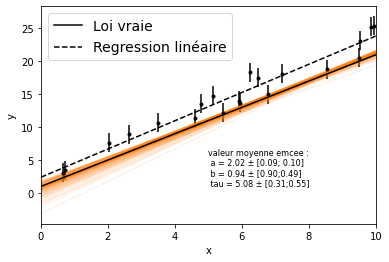

In [14]:
# Tracé graphique
sol=[]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    sol.append(mcmc[1])
    sol.append(q[0])
    sol.append(q[1])
    
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(4)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
    
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", label="Loi vraie")
plt.plot(x0, a_RL * x0 + b_RL, "--k", label="Regression linéaire")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.text(5,1, "valeur moyenne emcee :\n a = {0:.2f} ± [{1:.2f}; {2:.2f}]\n b = {3:.2f} ± [{4:.2f};{5:.2f}]\n tau = {6:.2f} ± [{7:.2f};{8:.2f}]"\
         .format(sol[0],sol[1],sol[2],sol[3],sol[4],sol[5],sol[6],sol[7],sol[8]),fontsize=8);

# Affichage des solutions : 
print("Estimation par maximum de vraisemblance :")
print("a = {0:.3f} ± {1:.3f}".format(sol[0],(sol[1]+sol[2])/2))
print("b = {0:.3f} ± {1:.3f}".format(sol[3],(sol[4]+sol[5])/2))
print("tau = {0:.3f} ± {1:.3f}".format(sol[6],(sol[7] +sol[8])/2))


Conformément au problème initial, les coefficients inférés respectent bien les contraintes liées aux incertitudes. Les coefficients a, b et même $\tau$ sont compatibles avec les paramètres initiaux utilisés pour générer les données. 

## Composition d'incertitudes des deux cas précédents

L’intérêt de cette partie est de montrer la possibilité de monter en complexité sur le problème initiale sans grand changement algorithmique. En effet, il suffit de reprendre le code précédent et d'en modifier uniquement la fonction de vraisemblance.

### Génération des données

In [25]:
""" Modules """
# Fonction erreur erf() :
from scipy.special import erf


""" Paramètres :"""
# Permet de varier l'initialisation du générateur pseudo-aléatoire
np.random.seed(120)          

# Paramètre du modèle afine : y = ax + b
a_vrai = 2
b_vrai = 1

# Paramètres des bruits aléatoires
sigma0 = 0.5
tau = 3



""" Génération de données à partir du modèle """
N = 20
Xdata = np.sort(10 * np.random.rand(N))
Yvrai = a_vrai * Xdata + b_vrai
Ydata = np.random.normal(Yvrai, sigma0) # Bruit gaussien
Ydata += np.random.uniform(0,  tau, N)


### Régression linéaire

Regression linéaire :
a_RL = 1.884 ± 0.040
b_RL = 3.015 ± 0.256


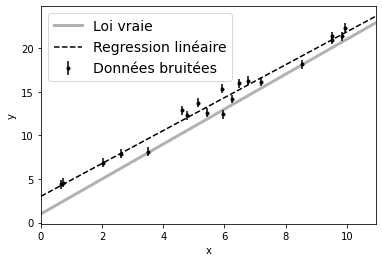

In [26]:
""" Régression linéaire : RL """

""" Permet de calculer le meilleur estimateur de a et b
connaissant un jeu de donnée {Xdata, Ydata}, l'incertitude suivant une 
statistique gausienne de paramètre sigma0 """

Out = IMM.LinearReg(Xdata,Ydata,sigma0)
a_RL = Out.A                #Estimateur de a_vrai    
b_RL = Out.B                #Estimateur de b_vrai
Sigma_a_RL = Out.SigmaA     #Ecart-type sur a
Sigma_b_RL = Out.SigmaB     #Ecart-type sur b

""" Tracé de data et de la regression linéaire"""
plt.figure(1)
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0, label = "Données bruitées")
x0 = np.linspace(0, max(Xdata)+1, 500)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", alpha=0.3, lw=3, label="Loi vraie")
plt.plot(x0, a_RL * x0 + b_RL, "--k", label="Regression linéaire")
plt.legend(fontsize=14)
plt.xlim(0, max(Xdata)+1)
plt.xlabel("x")
plt.ylabel("y");

print("Regression linéaire :")
print("a_RL = {0:.3f} ± {1:.3f}".format(Out.A,Out.SigmaA))
print("b_RL = {0:.3f} ± {1:.3f}".format(Out.B, Out.SigmaB))

La régression linéaire est bien évidement incapable de déterminer les paramètre a, b et $\tau$ et cette dernière fourni comme dans le cas précédant des paramètres a et b éloignés du modèle initiale.

Appliquons l'algorithme de maximisation de la fonction vraisemblance par chaîne de Markov.

### Fonction de vraisemblance

La procédure décrite dans la partie précédente est suffisamment faible en hypothèses pour pouvoir être utilisé systématiquement contrairement à la régression linéaire dont le cadre est très limité. La difficulté majeure résidant le plus souvent dans la détermination d'une fonction de vraisemblance répondant aux contraintes du problème.

Dans le cas où l'incertitude possède plusieurs sources, il faut être en mesure de les composer pour en tirer la fonction de vraisemblance pertinente.

En reprenant les deux cas précédant, les incertitudes ont pour formes :
\begin{equation*}
p_\text{uniforme} (y_i) = \left\{
    \begin{array}{ll}
        \dfrac{1}{\tau} & \mbox{si } 0 \leq y_i - y_\text{vrai} \leq \tau  \\
        0 & \mbox{sinon.}
    \end{array}
\right.
\end{equation*}

et 

\begin{equation*}
p_\text{gausienne}(y_\text{i}) = \dfrac{1}{\sigma_0\cdot\sqrt{2\pi}}\cdot \exp\left( \dfrac{1}{2}\cdot\left( \dfrac{y_\text{i} - y_\text{vrai}}{\sigma_0}\right)^2\right)
\end{equation*}

La fonction de vraisemblance pour une incertitude gaussienne de paramètre $\sigma_0$ et une incertitude uniforme $\tau$ est donc: 

\begin{equation*}
p(y_\text{data} |a, b, \tau ) = \prod_i \dfrac{1}{2\tau}\left[\text{erf} \left(\dfrac{\tau - (y_i - y_\text{vrai})}{2\sigma_0^2}\right) +\text{erf} \left(\dfrac{y_i - y_\text{vrai}}{2\sigma_0^2}\right) \right]
\end{equation*}


In [27]:
""" Maximisation de la fonction vraissemblance par échantillonage
par chaînes de Markov : exploration stochastique de l'espace des paramètres """


def log_FunVraissemblance(theta, x, y, sigma):
    a, b, tau = theta
    model = a * x + b
    sigma2 = 2*(sigma ** 2)
    X = y - model;
    Py = (erf((tau- X)/sigma2) + erf(X/sigma2))/(2*tau)
    #if (Py == 0).any() :
        #return -np.inf
    #if (tau < 2.5 or tau > 3.5 ):
        #return -np.inf
    return np.sum(np.log(Py))




Precision = 5

nwalkers = 5*Precision  # Paramètre EMCEE : nombre de "marcheurs"
nburn = 1000*Precision  #nombre de points avant stabilisation des chaînes
nsteps = nburn + 2000*Precision  # Paramètre EMCEE : nombre de pas

pos = [2,1,3] + 2e-1 * np.random.randn(nwalkers, 3) # Position initiale permettant d'accélérer la convergence
nwalkers, ndim = pos.shape# Paramètre EMCEE

#Algorithme EMCEE
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_FunVraissemblance, args=(Xdata, Ydata, sigma0))
sampler.run_mcmc(pos, nsteps, progress=True);
flat_samples = sampler.get_chain(discard=nburn, thin=15, flat=True)




  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]<ipython-input-27-584bb238053a>:15: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(Py))
100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:10<00:00, 1385.77it/s]


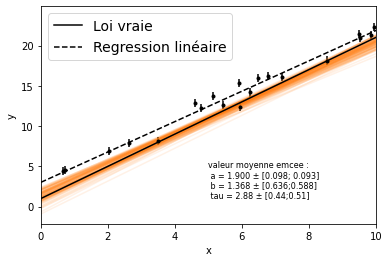

In [28]:
# Tracé graphique
sol=[]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    #txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    #txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #display(Math(txt))
    sol.append(mcmc[1])
    sol.append(q[0])
    sol.append(q[1])
    
    
a_sol = []    
mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84])
q = np.diff(mcmc)
a_sol.append(mcmc[1])
a_sol.append(q[0])
a_sol.append(q[1])
    

inds = np.random.randint(len(flat_samples), size=100)
plt.figure(4)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
    
plt.errorbar(Xdata, Ydata, yerr=sigma0, fmt=".k", capsize=0)
plt.plot(x0, a_vrai * x0 + b_vrai, "k", label="Loi vraie")
plt.plot(x0, a_RL * x0 + b_RL, "--k", label="Regression linéaire")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.text(5,1, "valeur moyenne emcee :\n a = {0:.3f} ± [{1:.3f}; {2:.3f}]\n b = {3:.3f} ± [{4:.3f};{5:.3f}]\n tau = {6:.2f} ± [{7:.2f};{8:.2f}]"\
         .format(sol[0],sol[1],sol[2],sol[3],sol[4],sol[5],sol[6],sol[7],sol[8]),fontsize=8);

Comme précédemment, cette technique permet d'inférer correctement les paramètres a, b et $\tau$ ainsi que les écart-types associés.

## Étude d'un modèle linéaire avec valeurs aberrantes

A faire.